In [64]:
import glob
import re
import json

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten,
                                     MaxPooling2D, Conv2D, Lambda,
                                     Concatenate)
import tensorflow_hub as hub

In [7]:
primary_path = '../webvision-2020-public/classification/data/'

In [8]:
# select 3 synsets at random
synsets = np.random.choice(glob.glob(primary_path + 'train/*'), 3, replace = False)
# get the labels
synset_labs = list()
for s in synsets:
    synset_labs.append(s.split('/')[-1])

In [9]:
synsets

array(['../webvision-2020-public/classification/data/train/n01663782',
       '../webvision-2020-public/classification/data/train/n04001265',
       '../webvision-2020-public/classification/data/train/n01534433'],
      dtype='<U60')

In [10]:
# paths to all images
img_paths = list()
for s in synsets:
    img_paths += glob.glob(s + '/*')

In [11]:
len(img_paths)

8962

In [12]:
def get_id_label_image(path, size):
    pic = Image.open(path)
    pic = pic.resize(size).convert('RGB')
    pic = np.array(pic) / 255
    
    path_sp = path.split('/')
    id_, label = path_sp[-1], path_sp[-2]
    return id_, label, pic

In [13]:
pic = get_id_label_image(img_paths[0], (300,300))
pic[2].shape

(300, 300, 3)

In [14]:
# downsample the image paths for memory
size = 600
val_size = 100
img_paths = np.random.choice(img_paths, size + val_size, replace = False)

In [16]:
IDs = list()
labels = list()
pics = list()

for imp in img_paths:
    id_, label, pic = get_id_label_image(imp, (300,300))
    IDs.append(id_.split('.')[0])
    labels.append(label)
    pics.append(pic)

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Find the corresponding metadata

In [15]:
# find all the json files
files = glob.glob(primary_path + 'google/*.json') + glob.glob(primary_path + 'flickr/*.json')

In [17]:
mapping = dict()

for file in files:
    with open(file, 'r') as f:
        lines = json.load(f)
        for item in lines:
            if item['id'] in IDs:
                mapping[item['id']] = [item['description'], item['title']]

### Prepare the Data

#### Images

In [27]:
train_images = np.vstack(pics[:size]).reshape(size, 300, 300, 3)
val_images = np.vstack(pics[size:]).reshape(val_size, 300, 300, 3)

#### Meta

In [23]:
descriptions = list()
titles = list()

for id_ in IDs:
    descriptions.append(
        mapping[id_][0]
    )
    titles.append(
        mapping[id_][1]
    )

train_desc = np.array(descriptions[:size])
val_desc = np.array(descriptions[size:])
train_titles = np.array(titles[:size])
val_titles = np.array(titles[size:])

#### Labels

In [28]:
le = LabelEncoder()
le.fit(labels)
train_labs = le.transform(labels[:size])
val_labs = le.transform(labels[size:])

## Image Only Model

In [106]:
inputs = Input(shape=(300,300,3), name = "input")
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(300,300,3))(inputs)
mpool1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mpool1)
mpool2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool2)
mpool3 = MaxPooling2D(2, 2)(conv3)
conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool3)
mpool4 = MaxPooling2D(2, 2)(conv4)
conv5 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool4)
mpool5 = MaxPooling2D(2, 2)(conv5)
flat = Flatten()(mpool5)
dp1 = Dropout(.1)(flat)
dense1 = Dense(256, activation='relu')(dp1)
dp2 = Dropout(.1)(dense1)
dense2 = Dense(64, activation='relu')(dp2)
dp3 = Dropout(.1)(dense2)
outputs = Dense(le.classes_.shape[0], activation = 'softmax')(dp3)
model = Model(inputs = inputs, outputs = outputs)

In [107]:
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 35, 35, 64)        0  

In [108]:
hist = model.fit(train_images, train_labs,
                 batch_size = 20, 
                 epochs = 20,
                 validation_data=(val_images, val_labs))

Train on 600 samples, validate on 100 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/sample - loss: 1.0028 - accuracy: 0.4717 - val_loss: 0.8924 - val_accuracy: 0.6600
Epoch 2/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.8868 - accuracy: 0.5617 - val_loss: 0.8937 - val_accuracy: 0.6000
Epoch 3/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.8306 - accuracy: 0.6167 - val_loss: 0.8906 - val_accuracy: 0.6300
Epoch 4/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.8455 - accuracy: 0.6150 - val_loss: 0.8751 - val_accuracy: 0.6000
Epoch 5/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.8008 - accuracy: 0.6517 - val_loss: 0.8010 - val_accuracy: 0.6900
Epoch 6/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.7883 - accuracy: 0.6317 - val_loss: 0.8336 - val_accuracy: 0.6300
Epoch 7/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.7568 - accur

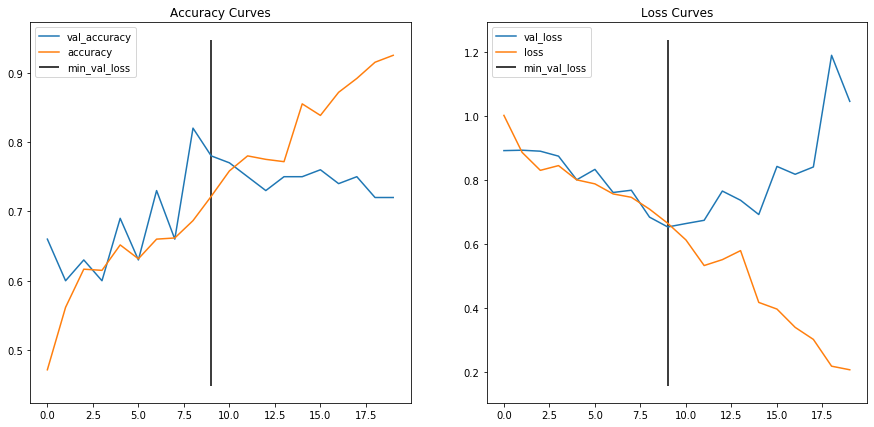

In [109]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend()
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

## Metadata Only Model

In [44]:
# load the USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# create USE layer
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [60]:
embed_size = 512

input_text1 = Input(shape=(1,), dtype=tf.string)
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string)
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)


x = Concatenate()([embedding1, embedding2])
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(le.classes_),activation='softmax',name='output')(x)
text_model = Model(inputs=[input_text1,input_text2], outputs=[output])
text_model.summary()

The following Variables were used a Lambda layer's call (lambda_8), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_8), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_9), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_9), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 512)          0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 512)          0           input_8[0][0]                    
____________________________________________________________________________________________

In [61]:
text_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [62]:
desc_titl_use_hist = text_model.fit(
                            [train_desc, train_titles], train_labs,
                            validation_data=([val_desc, val_titles], val_labs),
                            epochs=20,
                            batch_size=32
)

Train on 600 samples, validate on 100 samples
Epoch 1/20
600/600 [==============================] - 3s 5ms/sample - loss: 0.8721 - accuracy: 0.6700 - val_loss: 0.5849 - val_accuracy: 0.8500
Epoch 2/20
600/600 [==============================] - 0s 823us/sample - loss: 0.4239 - accuracy: 0.8583 - val_loss: 0.3117 - val_accuracy: 0.8800
Epoch 3/20
600/600 [==============================] - 0s 770us/sample - loss: 0.2430 - accuracy: 0.9250 - val_loss: 0.2677 - val_accuracy: 0.9000
Epoch 4/20
600/600 [==============================] - 0s 772us/sample - loss: 0.1835 - accuracy: 0.9350 - val_loss: 0.2362 - val_accuracy: 0.8900
Epoch 5/20
600/600 [==============================] - 0s 795us/sample - loss: 0.1435 - accuracy: 0.9600 - val_loss: 0.2596 - val_accuracy: 0.8900
Epoch 6/20
600/600 [==============================] - 1s 845us/sample - loss: 0.1396 - accuracy: 0.9383 - val_loss: 0.2499 - val_accuracy: 0.9000
Epoch 7/20
600/600 [==============================] - 0s 758us/sample - loss: 0.

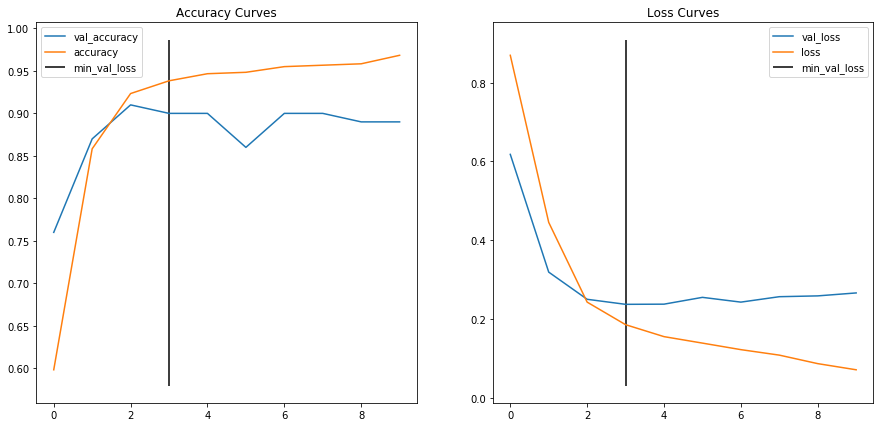

In [52]:
val_loss = desc_titl_use_hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(desc_titl_use_hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(desc_titl_use_hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend()
ax[1].plot(desc_titl_use_hist.history['val_loss'], label = 'val_loss')
ax[1].plot(desc_titl_use_hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

## Image and Metadata Model

In [54]:
embed_size = 512
# text part
input_text1 = Input(shape=(1,), dtype=tf.string, name = "input_text_1")
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string, name = "input_text_2")
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)
# image part
input_image = Input(shape=(300,300,3), name = "input_image")
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(300,300,3))(input_image)
mpool1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mpool1)
mpool2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool2)
mpool3 = MaxPooling2D(2, 2)(conv3)
conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool3)
mpool4 = MaxPooling2D(2, 2)(conv4)
conv5 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool4)
mpool5 = MaxPooling2D(2, 2)(conv5)
flat = Flatten()(mpool5)
# concat
x = Concatenate()([embedding1, embedding2, flat])
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(le.classes_),activation='softmax',name='output')(x)

comb_model = Model(inputs=[input_image, input_text1, input_text2], outputs=[output])
comb_model.summary()

The following Variables were used a Lambda layer's call (lambda_6), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_6), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 298, 298, 16) 448         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 149, 149, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 147, 147, 32) 4640        max_pooling2d_20[0][0]           
____________________________________________________________________________________________

In [55]:
comb_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
image_text_hist = comb_model.fit(
                            [train_images, train_desc, train_titles], train_labs,
                            validation_data=([val_images, val_desc, val_titles], val_labs),
                            epochs=20,
                            batch_size=32
)

Train on 600 samples, validate on 100 samples
Epoch 1/20
600/600 [==============================] - 5s 9ms/sample - loss: 0.9171 - accuracy: 0.5467 - val_loss: 0.7015 - val_accuracy: 0.5700
Epoch 2/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.6154 - accuracy: 0.7533 - val_loss: 0.4812 - val_accuracy: 0.8800
Epoch 3/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.3946 - accuracy: 0.8800 - val_loss: 0.3023 - val_accuracy: 0.8900
Epoch 4/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.2527 - accuracy: 0.9150 - val_loss: 0.2613 - val_accuracy: 0.8900
Epoch 5/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.1839 - accuracy: 0.9350 - val_loss: 0.2130 - val_accuracy: 0.9000
Epoch 6/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.1556 - accuracy: 0.9550 - val_loss: 0.2276 - val_accuracy: 0.8900
Epoch 7/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.1306 - accur

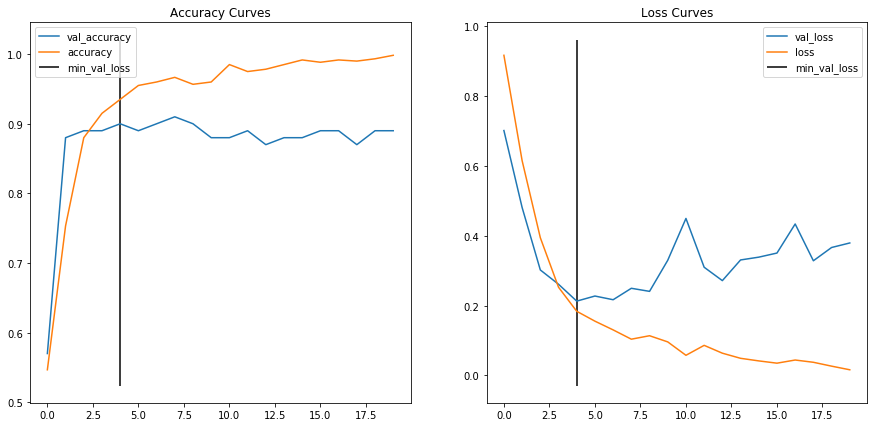

In [58]:
val_loss = image_text_hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(image_text_hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(image_text_hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend()
ax[1].plot(image_text_hist.history['val_loss'], label = 'val_loss')
ax[1].plot(image_text_hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

### Combined Plots

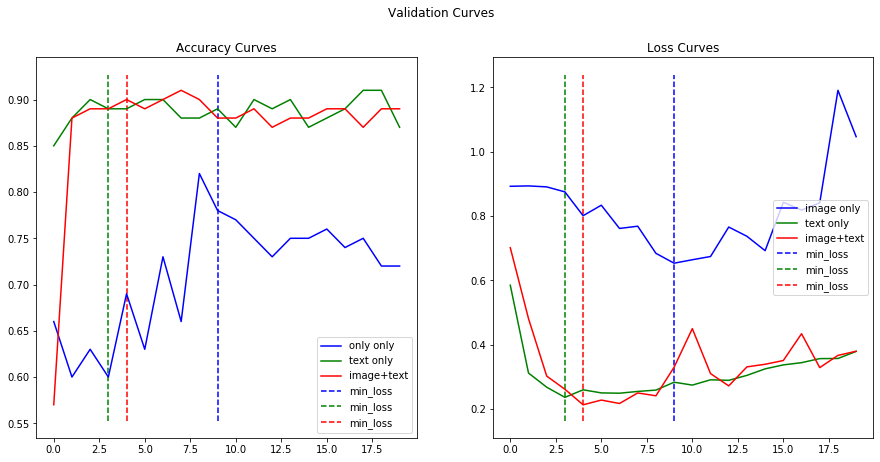

In [110]:
def get_min_val_loss_loc(history):
    val_loss = history.history['val_loss']
    min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]
    return min_loss_loc

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
fig.suptitle('Validation Curves')

ax[0].plot(hist.history['val_accuracy'], label = 'only only', color = 'b')
ax[0].plot(desc_titl_use_hist.history['val_accuracy'], label = 'text only', color = 'g')
ax[0].plot(image_text_hist.history['val_accuracy'], label = 'image+text', color = 'r')

ymin, ymax = ax[0].get_ylim()

ax[0].vlines(get_min_val_loss_loc(hist), ymin, ymax,
             linestyles = '--', color = 'b', label = 'min_loss')
ax[0].vlines(get_min_val_loss_loc(desc_titl_use_hist), ymin, ymax,
             linestyles = '--', color = 'g', label = 'min_loss')
ax[0].vlines(get_min_val_loss_loc(image_text_hist), ymin, ymax,
             linestyles = '--', color = 'r', label = 'min_loss')

ax[0].set_title('Accuracy Curves')
ax[0].legend()

ax[1].plot(hist.history['val_loss'], label = 'image only', color = 'b')
ax[1].plot(desc_titl_use_hist.history['val_loss'], label = 'text only', color = 'g')
ax[1].plot(image_text_hist.history['val_loss'], label = 'image+text', color = 'r')

ymin, ymax = ax[1].get_ylim()

ax[1].vlines(get_min_val_loss_loc(hist), ymin, ymax,
             linestyles = '--', color = 'b', label = 'min_loss')
ax[1].vlines(get_min_val_loss_loc(desc_titl_use_hist), ymin, ymax,
             linestyles = '--', color = 'g', label = 'min_loss')
ax[1].vlines(get_min_val_loss_loc(image_text_hist), ymin, ymax,
             linestyles = '--', color = 'r', label = 'min_loss')

ax[1].set_title('Loss Curves')
ax[1].legend(loc = 'center right');